## Get Results from old simulation
To run a new simulation, execute the `run_sim.py` script.
If the command below fails, you probably need to run a new simulation to generate data.

In [299]:
# Specific imports for cellular_raza
# The package is named cr_autophagy
# We want to reload the package when some of the behind-the scenes python functions change
# This is what the importlib statements are for
import importlib
import cr_pool_model as crp
importlib.reload(crp)

# Imports of general-purpose python libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pyvista as pv
import multiprocessing as mp
from pathlib import Path
import os
import tqdm

output_path = crp.get_last_output_path()
# output_path = Path("out/pool_model/2023-11-24-18:05:41")
simulation_settings = crp.get_simulation_settings(output_path)
max_iter = max(crp.get_all_iterations(output_path))

In [300]:
iter_0_particles = crp.get_elements_at_iter(output_path, 0)
print("Name".ljust(62), "Type")
print("⎯"*80)
for ty, col in zip(iter_0_particles.dtypes, iter_0_particles.columns):
    print("{}".format(col).ljust(62), "{}".format(ty))

Name                                                           Type
⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
identifier                                                     object
element.id                                                     object
element.parent_id                                              object
element.cell.mechanics.pos                                     object
element.cell.mechanics.vel                                     object
element.cell.mechanics.mass                                    float64
element.cell.mechanics.damping                                 float64
element.cell.mechanics.kb_temperature                          float64
element.cell.mechanics.update_interval                         int64
element.cell.mechanics.random_vector                           object
element.cell.interaction.potential_strength                    float64
element.cell.interaction.relative_interaction_range            float64
element

In [301]:
iter_0_voxels = crp.get_elements_at_iter(output_path, 0, element_path="voxel_storage")
print("Name".ljust(62), "Type")
print("⎯"*80)
for ty, col in zip(iter_0_voxels.dtypes, iter_0_voxels.columns):
    print("{}".format(col).ljust(62), "{}".format(ty))

Name                                                           Type
⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
identifier                                                     int64
element.plain_index                                            int64
element.index                                                  object
element.voxel.min                                              object
element.voxel.max                                              object
element.voxel.middle                                           object
element.voxel.dx                                               object
element.voxel.index                                            object
element.voxel.extracellular_concentrations                     object
element.voxel.extracellular_gradient                           object
element.voxel.diffusion_constant                               object
element.voxel.production_rate                                  object
element.voxel

## Read results from json Files
The results of the simulation are saved in json files.
Due to the parallelized nature of the simulation, not all results are in one big json file but rather in multiple batches. We therefore need to combine these batches to obtain a complete set for a given iteration.

In [302]:
df_cells = crp.get_elements_at_all_iterations(output_path, threads=10)
df_voxels = crp.get_elements_at_all_iterations(output_path, element_path="voxel_storage", threads=10)

We want to inspect which entries our generated dataset has. Therefore, we normalize the dict, transforming it into a dataframe.
Afterwards, we display all columns.

## Plot Colony
We plot the bacterial colony using `matplotlib`. All particles are represented by 2D spheres and so we can display them as such.

In [303]:
all_iterations = crp.get_all_iterations(output_path)

def calculate_total_nutrients_voxels(entry):
    mi = np.array([x for x in entry["element.voxel.min"]])
    ma = np.array([x for x in entry["element.voxel.max"]])
    diff = (ma-mi)**2
    conc = entry["element.voxel.extracellular_concentrations"]
    return np.sum(np.product(diff, axis=1) * conc)[0]

def calculate_total_nutrients_cells(entry):
    volume = np.pi*np.array([x for x in entry["element.cell.interaction.cell_radius"]])**2
    conc = entry["element.cell.cellular_reactions.intracellular_concentrations"][0]
    return np.sum(volume * conc)

total_nutrients_voxels = df_voxels.groupby("iteration").apply(calculate_total_nutrients_voxels)
total_nutrients_cells = df_cells.groupby("iteration").apply(calculate_total_nutrients_cells)
bacteria_count = df_cells.groupby("iteration").size()

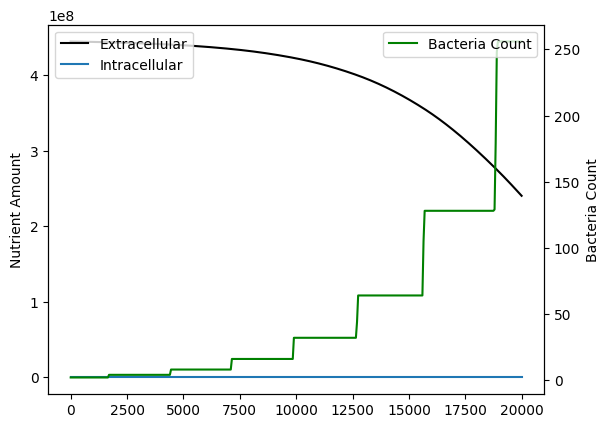

In [304]:
fig, ax1 = plt.subplots()

ax1.set_ylabel("Nutrient Amount")
ax1.plot(total_nutrients_voxels, label="Extracellular", color="black")
ax1.plot(total_nutrients_cells, label="Intracellular")

ax2 = ax1.twinx()
ax2.plot(bacteria_count, label="Bacteria Count", color="green")
ax2.set_ylabel("Bacteria Count")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show(fig)

In [305]:
import matplotlib
from matplotlib import pyplot as plt

simulation_settings = crp.get_simulation_settings(output_path)

def save_snapshot(iteration):
    save_path = Path(output_path) / "snapshot_{:08}.png".format(iteration)
    # if os.path.isfile(save_path):
    #     return None

    # Filter for only particles at the specified iteration
    df_cells_filtered = df_cells[df_cells["iteration"]==iteration]

    # Get positions as large numpy array
    positions = np.array([np.array(x) for x in df_cells_filtered["element.cell.mechanics.pos"]])
    s = np.array([np.array(x) for x in df_cells_filtered["element.cell.interaction.cell_radius"]])
    c = np.array([np.array(x) for x in df_cells_filtered["element.cell.cellular_reactions.intracellular_concentrations"]])
    norm = matplotlib.colors.Normalize(
        vmin=c.min(),
        vmax=c.max(),
        clip=True,
    )
    mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.summer)
    c = [mapper.to_rgba(ci) if not ci[0]==None else "red" for ci in c]

    xlims = np.array([0.0, simulation_settings.domain_size])
    ylims = np.array([0.0, simulation_settings.domain_size])

    figsize = (16, 16)
    fig, ax = plt.subplots(figsize=figsize)

    # Plot rectangles for background
    # Create color mapper for background
    nutrients_min = np.nanmin(df_voxels["element.voxel.extracellular_concentrations"])[0]
    norm2 = matplotlib.colors.Normalize(vmin=nutrients_min, vmax=simulation_settings.voxel_food_initial_concentration, clip=True)
    mapper2 = matplotlib.cm.ScalarMappable(norm=norm2, cmap=matplotlib.cm.gray)

    def plot_rectangle(entry):
        x_min = entry["element.voxel.min"]
        x_max = entry["element.voxel.max"]
        conc = entry["element.voxel.extracellular_concentrations"][0]

        xy = [x_min[0], x_min[1]]
        dx = x_max[0] - x_min[0]
        dy = x_max[1] - x_min[1]
        color = mapper2.to_rgba(conc) if not np.isnan(conc) else "red"
        rectangle = matplotlib.patches.Rectangle(xy, width=dy, height=dy, color=color)
        ax.add_patch(rectangle)

    df_voxels[df_voxels["iteration"]==iteration].apply(plot_rectangle, axis=1)

    # Plot circles for bacteria
    for pos, si, ci in zip(positions, s, c):
        if si==None:
            si = 0
        circle = plt.Circle(pos, radius=si, facecolor=ci, edgecolor='k')
        ax.add_patch(circle)

    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    fig.tight_layout()

    fig.savefig(save_path)
    plt.close(fig)

with mp.Pool() as p:
    _ = list(tqdm.tqdm(mp.Pool().imap(save_snapshot, all_iterations), total=len(all_iterations)))

100%|██████████| 401/401 [00:16<00:00, 23.99it/s]


In [306]:
# Also create a movie with ffmpeg
bashcmd = f"ffmpeg -y -r 30 -f image2 -pattern_type glob -i '{output_path}/*.png' -c:v h264 -pix_fmt yuv420p -strict -2 {output_path}/amovie_4.mp4"
os.system(bashcmd)

ffmpeg version n6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13.2.1 (GCC) 20230801
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libjxl --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librav1e --enable-librsvg --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpl --enable-libvpx --enable-libwebp --enable-libx264 --enable

0